# 1. MNIST

In [79]:
import os.path
from utils.joblib_wrapper import joblib_wrapper

from sklearn.datasets import fetch_openml


@joblib_wrapper('./datasets/mnist.pkl')
def load_mnist():
    _mnist = fetch_openml('mnist_784', cache=True, data_home='./datasets')
    return _mnist


mnist = load_mnist()

load_mnist发现位于./datasets/mnist.pkl的模型


In [80]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [81]:
import numpy as np
import pandas as pd

X, y = mnist['data'], mnist['target']  # type: pd.DataFrame, pd.Series

X.shape, y.shape

((70000, 784), (70000,))

(-0.5, 27.5, 27.5, -0.5)

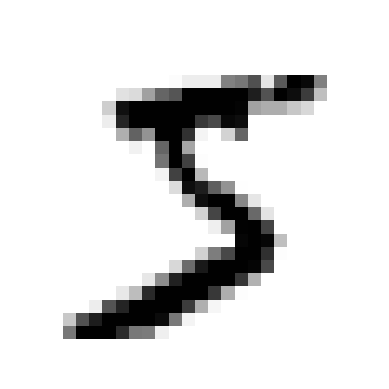

In [82]:
import matplotlib.pyplot as plt

some_digit = X.iloc[0]  # type: pd.Series
some_digit_image = some_digit.to_numpy().reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')

In [83]:
y[0]

'5'

In [84]:
y = y.astype(np.uint8)
y

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8

切分数据集，MNIST 数据集前 60000 个为训练集，后 10000 个为测试集:

In [85]:
X_train_df, y_train_df, X_test_df, y_test_df = X.iloc[:60000], y.iloc[:60000], X.iloc[60000:], y.iloc[
                                                                                               60000:]  # type: pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame

# 数据多太慢了，摘一部分出来
# 折叠十倍
fold = 10
train_sample_n = int(60000 / fold)
test_sample_n = int(10000 / fold)
random_state = 42

X_train = X_train_df.sample(n=train_sample_n, random_state=random_state).values  # type: np.ndarray
y_train = y_train_df.sample(n=train_sample_n, random_state=random_state).values  # type: np.ndarray
X_test = X_test_df.sample(n=test_sample_n, random_state=random_state).values  # type: np.ndarray
y_test = y_train_df.sample(n=test_sample_n, random_state=random_state).values  # type: np.ndarray

X_train.shape, X_test.shape

((6000, 784), (1000, 784))

# 2. 训练二元分类器

```SGDClassifier``` 随机梯度下降分类器(SVM 使用 SGD 训练)。

In [86]:
from sklearn.linear_model import SGDClassifier
from utils.joblib_wrapper import joblib_wrapper

y_train_5 = y_train == 5
y_test_5 = y_test == 5


@joblib_wrapper('./models/sgd_classifier.pkl')
def train_sgd_classifier() -> SGDClassifier:
    # 由于完全随机，为了复现结果，需要设置参数 random_state 
    _sgd_classifier = SGDClassifier(random_state=42)

    _sgd_classifier.fit(X_train, y_train_5)
    return _sgd_classifier


sgd_classifier = train_sgd_classifier()  # type: SGDClassifier

train_sgd_classifier发现位于./models/sgd_classifier.pkl的模型


In [87]:
score = sgd_classifier.score(X_test, y_test_5)
print(f"测试分数: {score}")

sgd_classifier.predict([some_digit])

测试分数: 0.842


array([ True])

# 3. 性能测量

## 3.1 使用交叉验证测量准确率

### 自实现交叉验证

以下代码和 ```cross_val_score()``` 方法类似。

In [88]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# n_splits n-折
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    # 复制分类器
    print(f"StratifiedKFold 采样: {train_index.shape}, {test_index.shape}")
    clone_clf = clone(sgd_classifier)
    # 采样
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    # 训练
    clone_clf.fit(X_train_folds, y_train_folds)

    # 准确率
    y_pred = clone_clf.predict(X_test_fold)
    n_corrent = sum(y_pred == y_test_fold)

    print(f'{n_corrent / len(y_pred)}')

StratifiedKFold 采样: (4000,), (2000,)
0.955
StratifiedKFold 采样: (4000,), (2000,)
0.9525
StratifiedKFold 采样: (4000,), (2000,)
0.952


In [89]:
from sklearn.model_selection import cross_val_score

# accuracy 准确率
cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring='accuracy', n_jobs=-1)

array([0.9505, 0.9535, 0.952 ])

## 3.2 混淆矩阵

In [90]:
from sklearn.model_selection import cross_val_predict

# 和 cross_val_score 类似，不过 cross_val_predict 返回的不是分数，而是测试结果
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, n_jobs=-1)

In [91]:
from sklearn.metrics import confusion_matrix

# 获取混淆矩阵


# 下面的矩阵
# 真负类（TN），假正类（FP）
# 假负类（FN），真正类（TP）
confusion_matrix(y_train_5, y_train_pred)

array([[5342,  107],
       [ 181,  370]])

* 准确率(正确的5占预测结果为5的数据的比例): $\frac{TP}{TP + FP}$
* 召回率(正确的5占实际标签为5的数据的比例): $\frac{TP}{TP + FN}$

## 3.3 精度和召回率

In [92]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.7756813417190775, 0.6715063520871143)

F1 分数：精度和召回率的调和平均值:

In [93]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7198443579766536

## 3.4 精度/召回率权衡

分数，可以通过设定阈值在自行判断 True/False

In [94]:
decision_score = sgd_classifier.decision_function([some_digit])

decision_score

array([3251.81547403])

In [95]:
threshold = 0

decision_score > threshold

array([ True])

In [96]:
threshold = 8000

decision_score > threshold

array([False])

In [97]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method='decision_function', n_jobs=-1)

y_scores

array([ -411893.02825144,  -429401.88212484,  -172808.66183802, ...,
        -481151.67466792, -1060345.84813847,    98784.42949312])

阈值，精度，召回率之间的关系

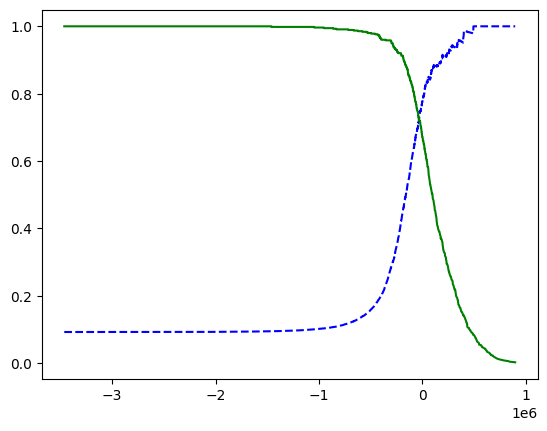

In [98]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


def plot_precision_recall_vs_threshold(precision_values, recall_values, threshold_values):
    plt.plot(threshold_values, precision_values[:-1], 'b--', label='Precision')
    plt.plot(threshold_values, recall_values[:-1], 'g-', label='Recall')


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

精度并不是随阈值越来越高的：当阈值到达一定程度有点数据可能会被划分到相反的分类去。

In [99]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

threshold_90_precision

181148.19352433295

In [100]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9022222222222223, 0.3684210526315789)

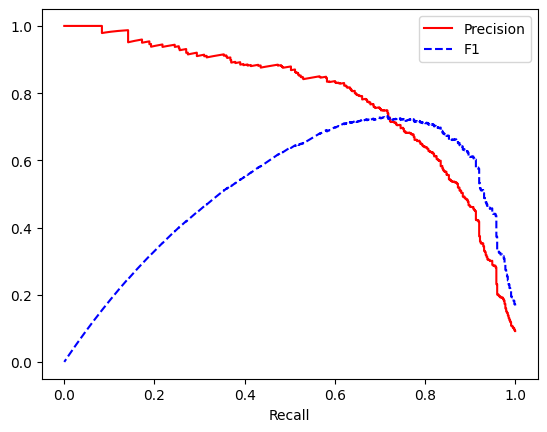

In [101]:

plt.plot(recalls, precisions, 'r', label='Precision')

f1_scores = 2 * recalls * precisions / (recalls + precisions)

plt.plot(recalls, f1_scores, 'b--', label='F1')
plt.xlabel('Recall')

plt.legend()

## 3.5 ROC 曲线

真阳率 / 假阳率


Text(0, 0.5, 'TPR')

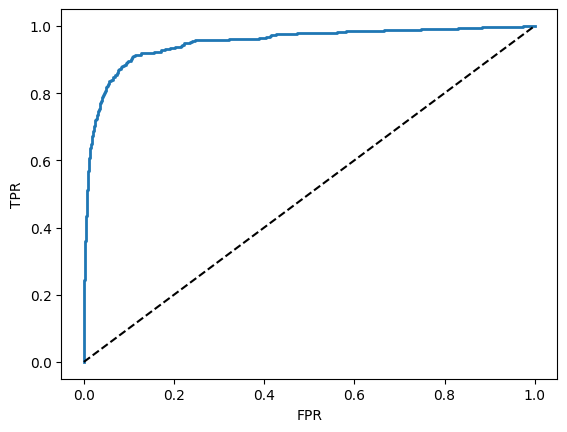

In [102]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')

虚线表示纯随机分类的 ROC 曲线，优秀的分类器应该离该曲线越远越好。

可以使用曲线下面积（AUC）来区分分类器的好坏：最好的 ROC AUC = 1，纯随机的 AUC = 0.5。

In [103]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9513439086543793

In [104]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
# predict_proba 
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba', n_jobs=-1)

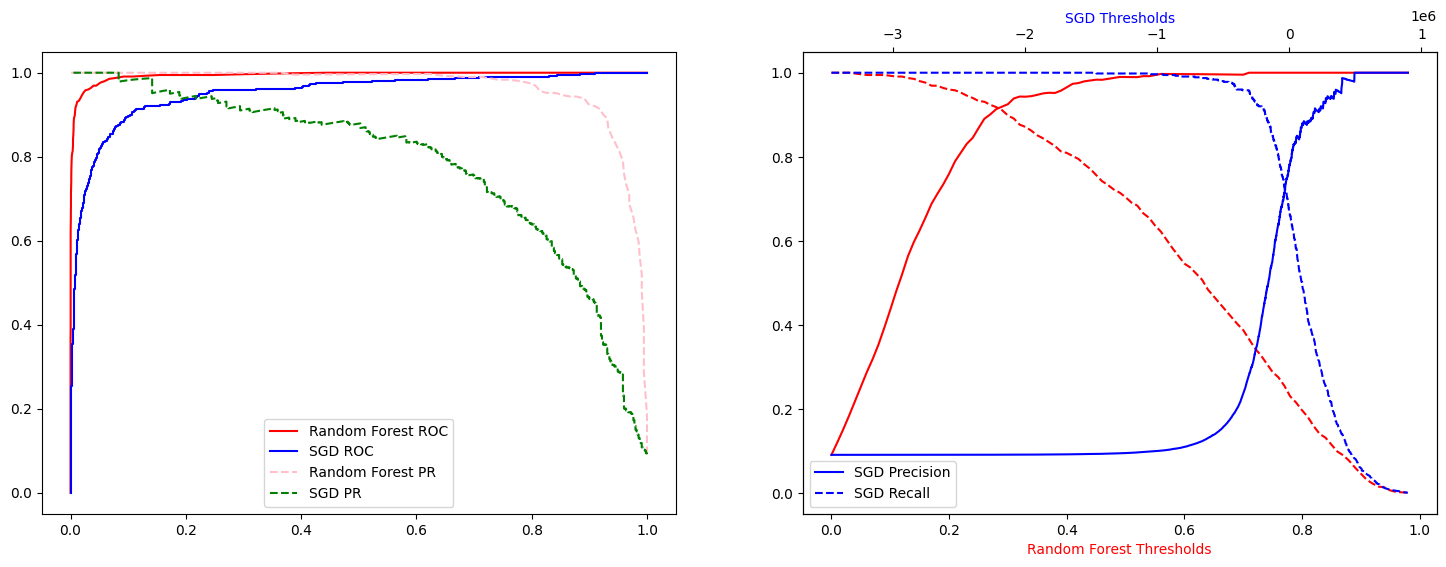

In [105]:
y_scores_forest = y_prob_forest[:, 1]

fpr_forest, tpr_forest, _ = roc_curve(y_train_5, y_scores_forest)
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

_, axes = plt.subplots(1, 2, figsize=(18, 6))  # type: plt.Figure, plt.Axes

ax = axes[0]

ax.plot(fpr_forest, tpr_forest, 'r-', label='Random Forest ROC')
ax.plot(fpr, tpr, 'b-', label='SGD ROC')

ax.plot(recalls_forest, precisions_forest, 'pink', linestyle='--', label='Random Forest PR')
ax.plot(recalls, precisions, 'g', linestyle='--', label='SGD PR')

z_ax = axes[1]  # type: plt.Axes
z_ax.plot(thresholds_forest, precisions_forest[:-1], 'r-', label='Random Forest Precision')
z_ax.plot(thresholds_forest, recalls_forest[:-1], 'r--', label='Random Forest Recall')
z_ax.set_xlabel('Random Forest Thresholds', color='r')

n_ax = axes[1].twiny()  # type: plt.Axes
n_ax.plot(thresholds, precisions[:-1], 'b-', label='SGD Precision')
n_ax.plot(thresholds, recalls[:-1], 'b--', label='SGD Recall')
n_ax.set_xlabel('SGD Thresholds', color='b')

n_ax.legend()
ax.legend()

# 4. 多类分类器

In [106]:
from sklearn.svm import SVC
from utils.joblib_wrapper import joblib_wrapper

svc_save_path = './models/svc.pkl'


@joblib_wrapper(svc_save_path)
def train_svc() -> SVC:
    svc_model = SVC(random_state=42)
    svc_model.fit(X_train, y_train)
    return svc_model


svc = train_svc()  # type: SVC

train_svc发现位于./models/svc.pkl的模型


In [107]:
svc.predict([some_digit])

array([5], dtype=uint8)

In [108]:
some_digit_scores = svc.decision_function([some_digit])
some_digit_scores

array([[ 1.7250158 ,  2.72809768,  7.25100028,  8.30763744, -0.3108725 ,
         9.31324842,  1.70975212,  2.76765879,  6.2304864 ,  4.84768564]])

In [109]:
np.argmax(some_digit_scores)

5

In [110]:
svc.classes_[5]

5

将数据标准化后可以提升精确率：

In [113]:
cross_val_score(sgd_classifier, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.8365, 0.8555, 0.8665])

In [112]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_classifier, x_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=-1)

array([0.89  , 0.8915, 0.899 ])

# 5. 误差分析

## 混淆矩阵

In [115]:
y_train_pred = cross_val_predict(sgd_classifier, x_train_scaled, y_train, cv=3, n_jobs=-1)

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[589,   0,   4,   1,   3,  16,   4,   0,   7,   0],
       [  0, 623,   8,   1,   0,   5,   0,   2,  14,   1],
       [  6,   4, 492,   7,   9,   2,  14,   8,  26,   4],
       [  8,   6,  16, 498,   1,  25,   3,   6,  18,   8],
       [  3,   2,   4,   2, 520,   3,   4,   2,  16,  24],
       [  9,   7,   9,  21,   9, 452,   7,   4,  26,   7],
       [  7,   0,   6,   1,  10,  15, 534,   0,   7,   0],
       [  1,   3,   7,   8,   9,   2,   0, 577,   4,  22],
       [  4,   8,   5,  12,   2,  20,   4,   3, 518,   9],
       [  8,   0,   5,   6,  17,   3,   0,  24,  11, 558]])

使用 plt 展示这个矩阵，方便观察。
在显示之前，先把数据的错误数改为错误率。

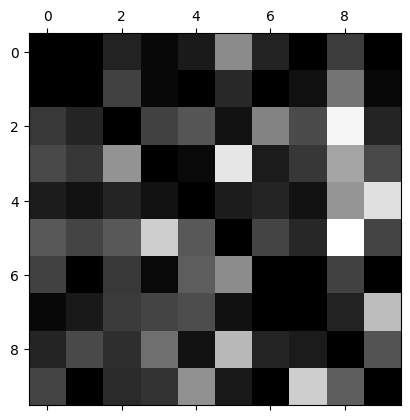

In [124]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap='gray')

由图可以看出：
* 3,5 会互相弄混；
* 很多 2,5 被错误分类成8；

# 6. 多标签

```KNeignborsClassifier```支持多标签分类。

In [135]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
# 矩阵左右结合
y_mult = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_mult)

KNeighborsClassifier()

In [136]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [137]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_mult, cv=3, n_jobs=-1)

f1_score(y_mult, y_train_knn_pred, average='weighted')

0.9524904012214166

# 7. 多输出分类

In [138]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = y_train
y_test_mod = y_test

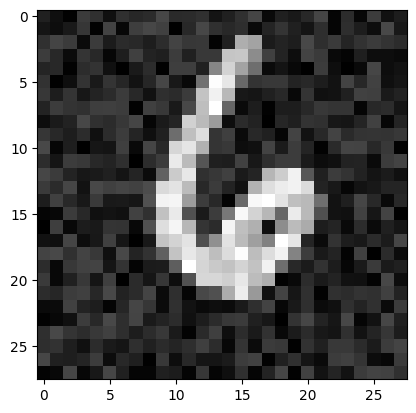

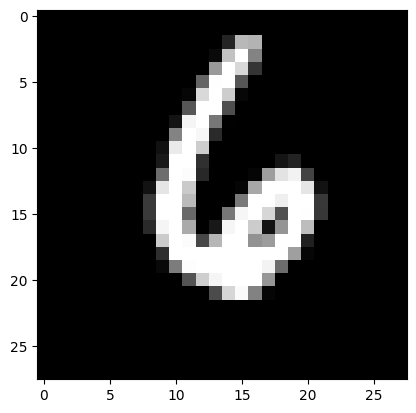

In [146]:
plt.imshow(X_test_mod[0].reshape(28, 28), cmap='gray')
plt.subplots()
plt.imshow(X_test[0].reshape(28, 28), cmap='gray')

In [148]:
knn_clf.fit(X_train_mod, y_train_mod)

clean_digit = knn_clf.predict([X_test_mod[0]])

clean_digit

array([6], dtype=uint8)

# 8. 练习题

## 8.1 MNIST 搜索 KNeighborsClassifier 的超参数

In [157]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

search_params = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6, 7, 8]}
]

X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values
y_test = y_test_df.values

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid=search_params, cv=5, n_jobs=-1, return_train_score=True, verbose=3)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [154]:
grid_search.best_params_, grid_search.best_score_

({'n_neighbors': 4, 'weights': 'distance'}, 0.9416666666666667)

In [156]:
from sklearn.metrics import accuracy_score
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.103